# EDA plots for thesis

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import cudf
import yaml
from datetime import datetime
import sklearn
from tqdm.auto import tqdm

with open(os.path.join("..", "config.yaml")) as f:
    main_cfg = yaml.load(f, Loader=yaml.FullLoader)
    
with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-alpha.yaml")) as f:
    amex_cfg = yaml.load(f, Loader=yaml.FullLoader)

with open(os.path.join("..", "src", "experiments", "configs", "experiment-config-beta.yaml")) as f:
    lob_cfg = yaml.load(f, Loader=yaml.FullLoader)

SystemError: initialization of _internal failed without raising an exception

## Synthetic dataset

In [2]:
from src.lib.synthetic_data import SyntheticData
from scipy import stats
from src.models.adaptive_grunet import AdaptiveGRUNet
from src.models.basic_grunet import GRUNetBasic
from src.preprocessing.static_transformations import StandardScalerTimeSeries
from src.preprocessing.adaptive_transformations import DAIN_Layer, BiN_Layer
from src.preprocessing.normalizing_flows import EDAIN_Layer, EDAINScalerTimeSeries, EDAINScalerTimeSeriesDecorator
from src.lib import experimentation
from scipy.integrate import quad, cumulative_trapezoid
import copy

DEV = torch.device('cuda', 5)

def evaluate_model(datasets, preprocess_init_fn=None, model_init_fn=None, input_dim=3, return_model=False):
    tlosses = []
    vlosses = []
    tmetrics = []
    vmetrics = []
    accs = []
    num_epochs = []

    for X, y in tqdm(datasets):
        N = X.shape[0]
        
        if model_init_fn is None:
            model = GRUNetBasic(input_dim, 32, 2, 2, 0)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        else:
            model = model_init_fn()
            optimizer = torch.optim.Adam([
                    {'params' : model.preprocess.parameters(), 'lr' : 1e-2},
                    {'params' : model.gru.parameters(), 'lr' : 1e-3},
                    {'params' : model.feed_forward.parameters(), 'lr' : 1e-3}
                ], lr = 0.001)
        loss_fn = F.binary_cross_entropy
        
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)
        early_stopper = experimentation.EarlyStopper(patience=5)

        # train-val split
        X_train, y_train = X[:int(N * 0.8)], y[:int(N * 0.8)]
        X_val, y_val = X[int(N * 0.8):], y[int(N * 0.8):]

        # preprocess the dataset if provided with a method
        if preprocess_init_fn is not None:
            preprocess = preprocess_init_fn()
            X_train = preprocess.fit_transform(X_train, y_train)
            X_val = preprocess.transform(X_val)

        train_loader = torch.utils.data.DataLoader(
                dataset = torch.utils.data.TensorDataset(
                    torch.from_numpy(X_train).type(torch.float32),
                    torch.from_numpy(y_train).type(torch.float32)),
                batch_size=128, shuffle = True)
        val_loader = torch.utils.data.DataLoader(
                dataset = torch.utils.data.TensorDataset(
                    torch.from_numpy(X_val).type(torch.float32),
                    torch.from_numpy(y_val).type(torch.float32)),
                batch_size=128, shuffle = True)

        history = experimentation.fit_model(model, loss_fn, train_loader, val_loader, optimizer, num_epochs=50, early_stopper=early_stopper, scheduler=scheduler, verbose=False, device_ids=DEV)
        
        if return_model and model_init_fn is not None:
            if preprocess_init_fn is not None:
                return model, preprocess
            else:
                return model
        elif return_model and preprocess_init_fn is not None:
            return preprocess
        elif return_model:
            raise ValueError("Invalid combination of arguments")

        # compute the classification binary accuracy
        val_preds = []
        val_labs = []
        for x_, y_ in val_loader:
            val_preds.append(model(x_.to(DEV)).detach().cpu().numpy())
            val_labs.append(y_.cpu().numpy())
        val_preds = np.concatenate(val_preds)
        val_labs = np.concatenate(val_labs)

        vlosses.append(history['val_loss'][-1])
        tlosses.append(history['train_loss'][-1])
        vmetrics.append(history['val_amex_metric'][-1])
        tmetrics.append(history['train_amex_metric'][-1])
        accs.append(np.mean(np.where(val_preds > 0.5, 1.0, 0.0) == val_labs))
        num_epochs.append(len(history['train_loss']))

    return {
        'val_loss' : np.array(vlosses),
        'val_amex_metric' : np.array(vmetrics),
        'train_loss' : np.array(tlosses),
        'train_amex_metric' : np.array(tmetrics),
        'val_accs' : np.array(accs),
        'num_epochs' : np.array(num_epochs),
    }

def cdf_invert(f, x, A=-50, B=50, n=40000):
    # cache the integral computation
    if f not in cdf_invert.cache:
        xs = np.linspace(A, B, n)
        Fs = cumulative_trapezoid(f(xs), xs, initial=0)
        Fs /= np.max(Fs)
        cdf_invert.cache[f] = Fs
    assert np.all(x > A) and np.all(x < B)
    # find the appropriate index by bucketing
    idx = np.array((x - A) * n / (B - A), dtype=np.int32)
    return cdf_invert.cache[f][idx]
cdf_invert.cache = {}

class UndoCorruptionTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, pdfs, time_series_length = 10, epsilon=1e-4):
        self.epsilon = epsilon
        self.T = time_series_length
        self.pdfs = pdfs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = copy.deepcopy(X)
        assert X.shape[2] == len(self.pdfs)
        for t in range(self.T):
            for j, f in enumerate(self.pdfs):
                # inverse normal CDF * original CDF
                X[:, t, j] = stats.norm.ppf(cdf_invert(f, X[:, t, j]) * (1 - self.epsilon) + self.epsilon / 2)
        return X

D = 3
T = 10
# lower bound, upper bound, and unormalized PDF
bounds = [(-8, 10), (-30, 30), (-1, 7)]
f1 = lambda x: 10 * stats.norm.cdf(10 * (x+4)) * stats.norm.pdf(x+4) + 0.1 * np.where(x > 8, np.exp(x - 8), 0) * np.where(x < 9.5, np.exp(9.5 - x), 0)
f2 = lambda x: np.where(x > np.pi, 20 * stats.norm.pdf(x-20), np.exp(x / 6) * (10 * np.sin(x) + 10))
f3 = lambda x: 2 * stats.norm.cdf(-4 * (x-4)) * stats.norm.pdf(x - 4)
# both of the two time-series will be q=3 and q=2, respecitvely
thetas = np.array([
    [-1., 0.5, -0.2, 0.8],
    [-1., 0.3, 0.9, 0.0],
    [-1., 0.8, 0.3, -0.9],
])
CROSS_VAR_SIGMA = 1.4
RESPONSE_NOISE_SIGMA = 0.5
RESPONSE_BETA_SIGMA = 2.0
RANDOM_STATE = 42
NUM_DATASETS = 50

synth_data = SyntheticData(
    dim_size=D,
    time_series_length=T,
    pdfs = [f1, f2, f3],
    ar_q = thetas.shape[1] - 1,
    ar_thetas=thetas,
    pdf_bounds=bounds,
    cross_variables_cor_init_sigma=CROSS_VAR_SIGMA,
    response_noise_sigma=RESPONSE_NOISE_SIGMA,
    response_beta_sigma=RESPONSE_BETA_SIGMA,
    random_state=RANDOM_STATE,
)

In [3]:
X_raw, y_raw = synth_data.generate_data(n=50000, return_uniform=False, random_state=0)
X_raw.shape

(50000, 10, 3)

In [62]:
z_score = evaluate_model([(X_raw, y_raw)], preprocess_init_fn=lambda : StandardScalerTimeSeries(10), return_model=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

In [63]:
inverse_scaler = evaluate_model([(X_raw, y_raw)], preprocess_init_fn=lambda : UndoCorruptionTimeSeries([f1, f2, f3], 10), return_model=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

In [76]:
bin_init_fn = lambda : AdaptiveGRUNet(
    BiN_Layer(input_shape=(3, 10)),
    3, 32, 2, 2, 0, 10, dim_first=True)
evaluate_model([(X_raw, y_raw)], model_init_fn=bin_init_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

{'val_loss': array([0.22186633]),
 'val_amex_metric': array([0.80343249]),
 'train_loss': array([0.23096175]),
 'train_amex_metric': array([0.79218746]),
 'val_accs': array([0.9012]),
 'num_epochs': array([13])}

In [74]:
dain_init_fn = lambda : AdaptiveGRUNet(
    DAIN_Layer(mode='adaptive_scale', input_dim=3),
    3, 32, 2, 2, 0, 10, dim_first=True)
evaluate_model([(X_raw, y_raw)], model_init_fn=dain_init_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

Mode =  adaptive_scale
Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Invalid combination of arguments

In [83]:
edain_local_init_fn = lambda : AdaptiveGRUNet(
    EDAIN_Layer(
        input_dim=3,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=True,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ), 3, 32, 2, 2, 0, 10, dim_first=False)
edain_local = evaluate_model([(X_raw, y_raw)], model_init_fn=edain_local_init_fn, return_model=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

In [65]:
edain_global_init_fn = lambda : AdaptiveGRUNet(
    EDAIN_Layer(
        input_dim=3,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=False,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ), 3, 32, 2, 2, 0, 10, dim_first=False)
edain_global, z_score_global = evaluate_model([(X_raw, y_raw)], preprocess_init_fn=lambda : StandardScalerTimeSeries(10), model_init_fn=edain_global_init_fn, return_model=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
edain_kl_preprocess = evaluate_model([(X_raw, y_raw)], preprocess_init_fn=lambda : EDAINScalerTimeSeriesDecorator(StandardScalerTimeSeries(10), 10, 3,
        bijector_kwargs={
            'init_sigma' : 0.0001,
            'eps' : 0.00001,
            'batch_aware' : False,
            'outlier_removal_mode' : 'exp',
        },
        bijector_fit_kwargs={
            'device' : DEV,
            'scale_lr' : 10,
            'shift_lr' : 10,
            'outlier_lr' : 10.0,
            'power_lr' : 10.0,
            'batch_size' : 1024,
            'milestones' : [4, 8],
            'num_epochs' : 20,
            'num_fits' : 1,
            'base_lr': 1e-3,
        }), return_model=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting bijector:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Transforming data using bijector:   0%|          | 0/40 [00:00<?, ?it/s]

Transforming data using bijector:   0%|          | 0/10 [00:00<?, ?it/s]

Using device = cuda:5


  0%|          | 0/50 [00:00<?, ?it/s]

In [84]:
X_local = edain_local.preprocess(torch.tensor(X_raw).to(DEV)).cpu().detach().numpy()
X_global = edain_global.preprocess(torch.tensor(z_score_global.transform(X_raw)).to(DEV)).cpu().detach().numpy()
X_edain_kl = edain_kl_preprocess.transform(X_raw)
X_ss = z_score.transform(X_raw)
X_invert = inverse_scaler.transform(X_raw)

Transforming data using bijector:   0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
plt.hist(X_raw[:, 0, 0], bins=200)
plt.show()

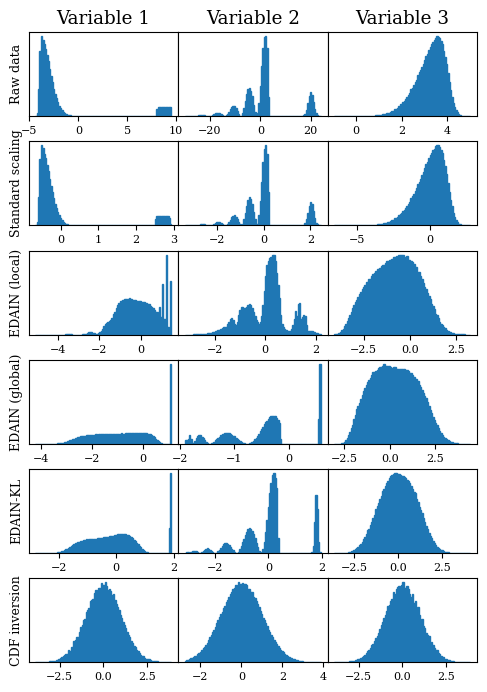

In [85]:
from src.lib.plotting import get_figsize, save_plot, update_plot_params

update_plot_params(**{"text.usetex":False})

methods = [X_raw, X_ss, X_local, X_global, X_edain_kl, X_invert]
meth_names = ["Raw data", "Standard scaling", "EDAIN (local)", "EDAIN (global)", "EDAIN-KL", "CDF inversion"]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=get_figsize(height_width_ratio=np.sqrt(2)))
# variable names
axs[0, 0].set_title("Variable 1")
axs[0, 1].set_title("Variable 2")
axs[0, 2].set_title("Variable 3")

# plot all the histograms
for i, (Xs, lab) in enumerate(zip(methods, meth_names)):
    axs[i, 0].set_ylabel(lab)
    for j in range(3):
        axs[i, j].set_yticks([])
    axs[i, 0].hist(Xs[:, :, 0].reshape((-1, 1)), bins=100, density=True, edgecolor='tab:blue')
    axs[i, 1].hist(Xs[:, :, 1].reshape((-1, 1)), bins=100, density=True, edgecolor='tab:blue')
    axs[i, 2].hist(Xs[:, :, 2].reshape((-1, 1)), bins=100, density=True, edgecolor='tab:blue')
plt.subplots_adjust(wspace=0, hspace=0.3)
#save_plot(fig, "synthetic_data_example_transformations")
plt.show()

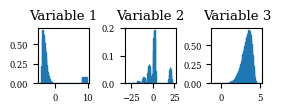

In [37]:
from src.lib.plotting import get_figsize, save_plot, update_plot_params

update_plot_params(**{"text.usetex":False, "font.size" : 8, "xtick.labelsize" : 6, "ytick.labelsize" : 6})

fig, axs = plt.subplots(ncols=3, figsize=get_figsize(height_width_ratio=1/4, fraction=0.5))

# variable names
axs[0].set_title("Variable 1")
axs[1].set_title("Variable 2")
axs[2].set_title("Variable 3")
for i in range(3):
    axs[i].hist(X_raw[:, :, i].reshape((-1, 1)), bins=100, density=True, edgecolor='tab:blue')

plt.subplots_adjust(wspace=0.7, hspace=0)

#fig.tight_layout()
save_plot(fig, "synthetic_data_eda_for_paper")
plt.show()

### Looking at experiment results

In [16]:
from src.lib.plotting import load_hist

methods = ["raw", "z_score", "inverse_CDF", "bin", "dain", "edain_local", "edain_global", "edain-kl"]

hists = [load_hist(f"synth_data_performance_{lab}") for lab in methods]

res_data = {
    "method" : [],
    "val_loss" : [],
    "val_amex_metric" : [],
    "val_accs" : [],
    "num_epochs" : [],
}
for h, lab in zip(hists, methods):
    for k in res_data.keys():
        if "improvement" in k:
            continue
        elif k == "method":
            res_data[k].append(lab)
        else:
            m = np.mean(h[k])
            s = np.std(h[k])
            res_data[k].append(f"${m:.4f} \pm {1.96 * s:.4f}$")
            # look at improvement compared to standard scaling
#             if f"{k}_improvement" not in res_data:
#                 res_data[f"{k}_improvement"] = []
#             vs = 1 - h[k] / hists[1][k]
#             m = np.mean(vs)
#             s = np.std(vs)
#             res_data[f"{k}_improvement"].append(f"${m:.4f} \pm {1.96 * s:.4f}$")
            

df = pd.DataFrame(res_data)
print(df.to_latex(index=False))
df

\begin{tabular}{lllll}
\toprule
      method &            val\_loss &     val\_amex\_metric &            val\_accs &            num\_epochs \\
\midrule
         raw & \$0.1900 \textbackslash pm 0.0362\$ & \$0.8268 \textbackslash pm 0.0359\$ & \$0.9168 \textbackslash pm 0.0168\$ & \$24.2000 \textbackslash pm 11.5357\$ \\
     z\_score & \$0.1873 \textbackslash pm 0.0108\$ & \$0.8306 \textbackslash pm 0.0136\$ & \$0.9173 \textbackslash pm 0.0065\$ & \$19.2100 \textbackslash pm 10.0680\$ \\
 inverse\_CDF & \$0.1627 \textbackslash pm 0.0094\$ & \$0.8504 \textbackslash pm 0.0123\$ & \$0.9289 \textbackslash pm 0.0055\$ &  \$18.6800 \textbackslash pm 9.8230\$ \\
         bin & \$0.2191 \textbackslash pm 0.0103\$ & \$0.8009 \textbackslash pm 0.0120\$ & \$0.9036 \textbackslash pm 0.0059\$ &  \$17.1700 \textbackslash pm 7.5253\$ \\
        dain & \$0.2153 \textbackslash pm 0.0146\$ & \$0.8077 \textbackslash pm 0.0152\$ & \$0.9048 \textbackslash pm 0.0078\$ & \$20.0300 \textbackslash pm 11.3425\$

/tmp/ipykernel_174875/3269041417.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


,method,val_loss,val_amex_metric,val_accs,num_epochs
0,raw,$0.1900 \pm 0.0362$,$0.8268 \pm 0.0359$,$0.9168 \pm 0.0168$,$24.2000 \pm 11.5357$
1,z_score,$0.1873 \pm 0.0108$,$0.8306 \pm 0.0136$,$0.9173 \pm 0.0065$,$19.2100 \pm 10.0680$
2,inverse_CDF,$0.1627 \pm 0.0094$,$0.8504 \pm 0.0123$,$0.9289 \pm 0.0055$,$18.6800 \pm 9.8230$
3,bin,$0.2191 \pm 0.0103$,$0.8009 \pm 0.0120$,$0.9036 \pm 0.0059$,$17.1700 \pm 7.5253$
4,dain,$0.2153 \pm 0.0146$,$0.8077 \pm 0.0152$,$0.9048 \pm 0.0078$,$20.0300 \pm 11.3425$
5,edain_local,$0.2099 \pm 0.0095$,$0.8110 \pm 0.0109$,$0.9071 \pm 0.0057$,$18.0600 \pm 9.4764$
6,edain_global,$0.1636 \pm 0.0086$,$0.8506 \pm 0.0110$,$0.9283 \pm 0.0051$,$18.9800 \pm 9.7803$
7,edain-kl,$0.1760 \pm 0.0094$,$0.8402 \pm 0.0111$,$0.9224 \pm 0.0059$,$18.0000 \pm 9.7292$


## Amex dataset

In [10]:
from src.lib.experimentation import load_amex_numpy_data, undo_min_max_corrupt_func
import pandas as pd
import numpy as np 
import seaborn as sns
from src.lib.plotting import get_figsize, save_plot, update_plot_params

COLS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68', 'D_63', 'D_64', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']

In [ ]:
X_train, y_train = load_amex_numpy_data(
    os.path.join(main_cfg['dataset_directory'], "derived", "processed-splits"),
    amex_cfg['amex_dataset']['fill'],
    lambda X, y: undo_min_max_corrupt_func(X, y, 42),
    11,
)
print(X_train.shape)

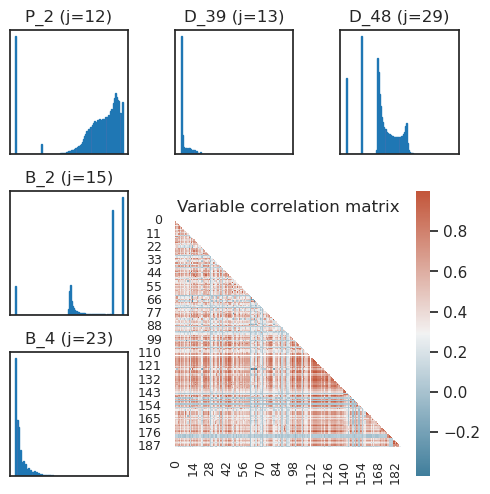

In [79]:
# Setup plot
update_plot_params(**{"text.usetex":False})
sns.set_theme(style="white")
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=get_figsize(height_width_ratio=np.sqrt(1)))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
gs = axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in axs[1:, 1]:
    ax.remove()
for ax in axs[1:, 2]:
    ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])

# put the variables in the dataframe
d = pd.DataFrame(data=X_train[:10000, :, :].reshape((-1, X_train.shape[2])),
                 columns=None)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=None, ax=axbig,
            square=True, linewidths=0, cbar_kws={"shrink": 1, "ticks" : [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]})
b.tick_params(labelsize=9)
axbig.set_title("Variable correlation matrix")

# Make the histograms
axes = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[2, 0]]
var_names = ["P_2", "D_39", "D_48", "B_2", "B_4"]

for i, (ax, lab) in enumerate(zip(axes, var_names)):
    data = X_train[:10000, :, COLS.index(lab)].reshape((-1))
    ax.hist(data, bins=100, density=True, edgecolor='tab:blue')
    ax.set_title(f"{lab} (j={COLS.index(lab)+1})")
    ax.set_xticks([])
    ax.set_yticks([])
# fig.tight_layout()
save_plot(fig, "amex_data_eda_plot")

## LOB dataset

In [81]:
from src.lib.lob_loader import get_wf_lob_loaders
from src.lib.lob_train_utils import lob_epoch_train_one_epoch, lob_evaluator
from src.models.adaptive_grunet import AdaptiveGRUNetLOB
from src.preprocessing.static_transformations import StandardScalerTimeSeries
from src.preprocessing.adaptive_transformations import DAIN_Layer, BiN_Layer
from src.preprocessing.normalizing_flows import EDAIN_Layer, EDAINScalerTimeSeries, EDAINScalerTimeSeriesDecorator


In [83]:
train_loader, val_loader = get_wf_lob_loaders(
    h5_path=lob_cfg['lob_dataset']['preprocessed_lob_path'],
    window=15,
    horizon=2,
    split=8,
    batch_size=128,
)

X_train = []
for X, y in tqdm(train_loader, desc="Preprocess"):
    X_train.append(X.numpy())
X_train = np.concatenate(X_train, axis=0)
X_train.shape

Preprocess:   0%|          | 0/3259 [00:00<?, ?it/s]

(417060, 15, 144)

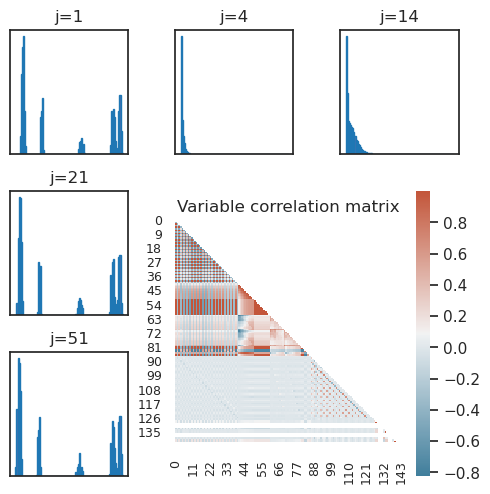

In [92]:
# EDA plot for LOB dataset
update_plot_params(**{"text.usetex":False})
sns.set_theme(style="white")
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=get_figsize(height_width_ratio=np.sqrt(1)))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
gs = axs[1, 2].get_gridspec()
# remove the underlying axes
for ax in axs[1:, 1]:
    ax.remove()
for ax in axs[1:, 2]:
    ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])

# put the variables in the dataframe
d = pd.DataFrame(data=X_train[:10000, :, :].reshape((-1, X_train.shape[2])),
                 columns=None)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
b = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=None, ax=axbig,
            square=True, linewidths=0, cbar_kws={"shrink": 1, "ticks" : [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]})
b.tick_params(labelsize=9)
axbig.set_title("Variable correlation matrix")

# Make the histograms
axes = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[2, 0]]
js = sorted([13, 50, 20, 3, 0])
#js = [100, 120, 89, 3, 0]

for i, (ax, j) in enumerate(zip(axes, js)):
    data = X_train[:10000, :, j].reshape((-1))
    ax.hist(data, bins=100, density=True, edgecolor='tab:blue')
    ax.set_title(f"j={j+1}")
    ax.set_xticks([])
    ax.set_yticks([])
# fig.tight_layout()
save_plot(fig, "lob_data_eda_plot")
# plt.show()

### Big model and optimizer cell

In [24]:
################################### local EDAIN ################################
edain_model = AdaptiveGRUNetLOB(
    adaptive_layer=EDAIN_Layer(
        input_dim=144,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=True,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ),
    time_series_length=15,
    dim_first=False,
    input_dim=144,
)

edain_optimizer = torch.optim.RMSprop(
    edain_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        # For local-aware
        scale_lr=0.0001,
        shift_lr=0.01,
        outlier_lr=10.0,
        power_lr=0.1,
        # below for global-aware
        # scale_lr: 10.0
        # shift_lr: 10.0
        # outlier_lr: 0.000001
        # power_lr: 0.001
        # # below for EDAIN-KL
        # scale_lr: 0.0001
        # shift_lr: 0.01
        # outlier_lr: 10.0
        # power_lr: 0.001
    ) + [
        {'params' : edain_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : edain_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

################################### global EDAIN ################################
edain_global_model = AdaptiveGRUNetLOB(
    adaptive_layer=EDAIN_Layer(
        input_dim=144,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=False,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ),
    time_series_length=15,
    dim_first=False,
    input_dim=144,
)

edain_global_optimizer = torch.optim.RMSprop(
    edain_global_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        # For local-aware
        # scale_lr=0.0001,
        # shift_lr=0.01,
        # outlier_lr=10.0,
        # power_lr=0.1,
        # below for global-aware
        scale_lr=10.0,
        shift_lr=10.0,
        outlier_lr=0.000001,
        power_lr=0.001,
        # # below for EDAIN-KL
        # scale_lr: 0.0001
        # shift_lr: 0.01
        # outlier_lr: 10.0
        # power_lr: 0.001
    ) + [
        {'params' : edain_global_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : edain_global_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

################################### DAIN ################################
dain_model = AdaptiveGRUNetLOB(
    adaptive_layer=DAIN_Layer(
        mode='adaptive_scale',
        input_dim=144,
        mean_lr=0.01,
        scale_lr=0.00000001,
        gate_lr=10,
    ),
    time_series_length=15,
    dim_first=True,
    input_dim=144,
)

dain_optimizer = torch.optim.RMSprop(
    dain_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
    ) + [
        {'params' : dain_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : dain_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

#################################### BIN ###############################
bin_model = AdaptiveGRUNetLOB(
    adaptive_layer=BiN_Layer(
        input_shape=(144, 15),
    ),
    time_series_length=15,
    dim_first=True,
    input_dim=144,
)

bin_optimizer = torch.optim.RMSprop(
    bin_model.preprocess.get_optimizer_param_list(
        base_lr=1e-4,
        beta_lr=1.0,
        gamma_lr=0.00000001,
        lambda_lr=0.1,
    ) + [
        {'params' : bin_model.gru.parameters(), 'lr' : 1e-4},
        {'params' : bin_model.feed_forward.parameters(), 'lr' : 1e-4},
    ], lr=1e-4)

Mode =  adaptive_scale


### Fit runner and loader cell

In [104]:
# fit the model
torch.multiprocessing.set_sharing_strategy('file_system')
np.random.seed(42)
torch.manual_seed(42)
DEV = torch.device('cuda', 5)

FIT_PREPROCESS = False
FIT_EDAIN = False
FIT_EDAIN_GLOBAL = False
FIT_BIN = False
FIT_DAIN = False
FIT_EDAIN_KL = False

if FIT_PREPROCESS:
    # fit the standard scaler first on the training data
    preprocess = StandardScalerTimeSeries(15)
    X_train = []
    y_train = []
    for X, y in tqdm(train_loader, desc="Preprocess"):
        X_train.append(X.numpy())
        y_train.append(y.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    print("Fitting standard scaler")
    X_train_ss = preprocess.fit_transform(X_train)
    print("Done!")

if FIT_EDAIN:
    edain_model = edain_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(edain_model, train_loader, preprocess, edain_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(edain_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain_local-aware_lob"))
else:
    edain_model = edain_model.cpu()
    edain_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain_local-aware_lob")))
    edain_model.eval()
    
if FIT_EDAIN_GLOBAL:
    edain_global_model = edain_global_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(edain_global_model, train_loader, preprocess, edain_global_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(edain_global_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain_global-aware_lob"))
else:
    edain_global_model = edain_global_model.cpu()
    edain_global_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain_global-aware_lob")))
    edain_global_model.eval()
    
if FIT_DAIN:
    dain_model = dain_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(dain_model, train_loader, None, dain_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(dain_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "dain_lob"))
else:
    dain_model = dain_model.cpu()
    dain_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "dain_lob")))
    dain_model.eval()
    
if FIT_BIN:
    bin_model = bin_model.to(DEV)
    for i in tqdm(range(20)):
        train_loss = lob_epoch_train_one_epoch(bin_model, train_loader, None, bin_optimizer, DEV)
        print(f"Epoch {i+1}: Train loss = {train_loss:.8f}") 
    torch.save(bin_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "bin_lob"))
else:
    bin_model = bin_model.cpu()
    bin_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "bin_lob")))
    bin_model.eval()
    
if True:
    edain_kl = EDAINScalerTimeSeriesDecorator(
        scaler=StandardScalerTimeSeries(15),
        time_series_length=15,
        input_dim=144,
        bijector_kwargs={
            'init_sigma' : 0.0001,
            'eps' : 0.00001,
            'batch_aware' : False,
            'outlier_removal_mode' : 'exp',
        },
        bijector_fit_kwargs={
            'device' : DEV,
            'scale_lr' : 0.0001,
            'shift_lr' : 0.01,
            'outlier_lr' : 10.0,
            'power_lr' : 0.01,
            'batch_size' : 1024,
            'milestones' : [3, 7],
            'num_epochs' : 8 if FIT_EDAIN_KL else 1,
            'num_fits' : 1,
            'base_lr': 1e-2,
        })
    if FIT_EDAIN_KL:
        X_train_edain_kl = edain_kl.fit_transform(X_train, y_train)
        torch.save(edain_kl.bijector.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain-kl-bijector"))
    else:
        edain_kl.fit(X_train[:2000], y_train[:2000])
        edain_kl.bijector.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain-kl-bijector")))
        edain_kl.bijector.eval()
        X_train_edain_kl = edain_kl.transform(X_train)

Fitting bijector:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Transforming data using bijector:   0%|          | 0/408 [00:00<?, ?it/s]

In [45]:
def transform_data(mod, dim_first=False, z_score=False):
    mod = mod.to(DEV)
    X_train_transformed = []
    for X, _ in tqdm(train_loader, desc="Transforming data"):
        if z_score:
            X = torch.tensor(preprocess.transform(X))
        X = X.to(DEV)
        if dim_first:
            X = X.transpose(1, 2)
        X_out = mod.preprocess(X)
        if dim_first:
            X_out = X_out.transpose(1, 2)
        X_train_transformed.append(X_out.detach().cpu().numpy())
    mod = mod.cpu()
    return np.concatenate(X_train_transformed, axis=0)


X_train_edain = transform_data(edain_model, z_score=True)
X_train_dain = transform_data(dain_model, dim_first=True)
X_train_bin = transform_data(bin_model, dim_first=True)
X_train_edain_global = transform_data(edain_global_model, z_score=True)

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

Transforming data:   0%|          | 0/3259 [00:00<?, ?it/s]

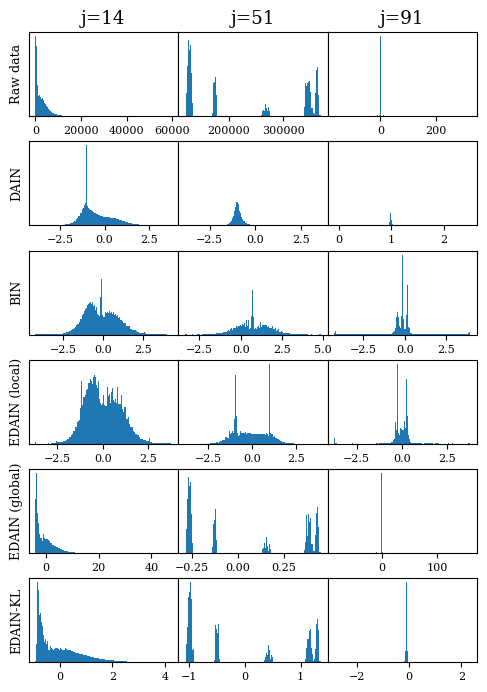

In [121]:
# below is full plotting code
# TODO: trian EDAIN-KL for longer so that more illustrative plots for it!
#       When doing this, can also add option for merging time and sample axis
#       so that can train for plots better with only D unknown params...
from src.lib.plotting import get_figsize, save_plot, update_plot_params

update_plot_params(**{"text.usetex":False})
get_figsize(height_width_ratio=np.sqrt(2))

methods = [X_train, X_train_dain, X_train_bin, X_train_edain, X_train_edain_global, X_train_edain_kl]
meth_names = ["Raw data", "DAIN", "BIN", "EDAIN (local)", "EDAIN (global)", "EDAIN-KL"]

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=get_figsize(height_width_ratio=np.sqrt(2)))
# variable names
axs[0, 0].set_title("j=14")
axs[0, 1].set_title("j=51")
axs[0, 2].set_title("j=91")

# plot all the histograms
for i, (Xs, lab) in enumerate(zip(methods, meth_names)):
    axs[i, 0].set_ylabel(lab)
    for j in range(3):
        axs[i, j].set_yticks([])
    axs[i, 0].hist(Xs[:, :, 13].reshape((-1, 1)), bins=200, density=True)
    axs[i, 1].hist(Xs[:, :, 50].reshape((-1, 1)), bins=200, density=True)
    axs[i, 2].hist(Xs[:, :, 90].reshape((-1, 1)), bins=200, density=True)
plt.subplots_adjust(wspace=0, hspace=0.3)
save_plot(fig, "lob_example_transformations")

## Amex data example plots

In [2]:
from src.lib.experimentation import load_amex_numpy_data, undo_min_max_corrupt_func, fit_model
import pandas as pd
import numpy as np 
import seaborn as sns
from src.lib.plotting import get_figsize, save_plot, update_plot_params

COLS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68', 'D_63', 'D_64', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']

torch.multiprocessing.set_sharing_strategy('file_system')
np.random.seed(42)
torch.manual_seed(42)
DEV = torch.device('cuda', 5)



In [3]:
from src.preprocessing.static_transformations import StandardScalerTimeSeries, IgnoreTimeDecorator

# load the data
X_raw, y_raw = load_amex_numpy_data(
    os.path.join(main_cfg['dataset_directory'], "derived", "processed-splits"),
    amex_cfg['amex_dataset']['fill'],
    None, # lambda X, y: undo_min_max_corrupt_func(X, y, 42),
    11,
)

preprocess = IgnoreTimeDecorator(StandardScalerTimeSeries(1), 13)
X_train = np.concatenate((X_raw[:, :, :11], preprocess.fit_transform(X_raw[:, :, 11:], y_raw)), axis=2)

print(X_train.shape)

(458913, 13, 188)


In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_raw).float(),
    ), 
    **amex_cfg['amex_dataset']['data_loader']
)
val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(X_train[:10000]).float(),
        torch.from_numpy(y_raw[:10000]).float(),
    ), 
    **amex_cfg['amex_dataset']['data_loader']
)

In [6]:
from src.models.adaptive_grunet import AdaptiveGRUNet
from src.preprocessing.normalizing_flows import EDAIN_Layer

TRAIN_EDAIN_MODEL = True

edain_model = AdaptiveGRUNet(
    adaptive_layer=EDAIN_Layer(
        input_dim=177,
        invert_bijector=False,
        outlier_removal_residual_connection=True,
        batch_aware=False,
        init_sigma=0.000001,
        outlier_removal_mode='exp',
    ),
    num_features=188,
    num_cat_columns=11,
    hidden_dim=128,
    layer_dim=2,
    embedding_dim=4,
    time_series_length=13,
    dim_first=False,
)

optim = torch.optim.Adam(
    edain_model.preprocess.get_optimizer_param_list(
        base_lr=1e-3,
        # For local-aware
        # scale_lr=0.0001,
        # shift_lr=0.01,
        # outlier_lr=10.0,
        # power_lr=0.1,
        # below for global-aware
        scale_lr=0.01,
        shift_lr=0.01,
        outlier_lr=100.0,
        power_lr=10.0,
        # # below for EDAIN-KL
        # scale_lr: 0.0001
        # shift_lr: 0.01
        # outlier_lr: 10.0
        # power_lr: 0.001
    ) + [
        {'params' : edain_model.gru.parameters(), 'lr' : 1e-3},
        {'params' : edain_model.feed_forward.parameters(), 'lr' : 1e-3},
        {'params' : edain_model.emb_layers.parameters(), 'lr' : 1e-3 },
    ], lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[4, 7], gamma=0.1)

if TRAIN_EDAIN_MODEL:
    history = fit_model(edain_model, F.binary_cross_entropy, train_loader, val_loader, optim, scheduler, num_epochs=20, device_ids=DEV) #torch.device('cpu'))
    torch.save(edain_model.state_dict(), os.path.join(main_cfg['checkpoint_directory'], "edain_amex_checkpoint"))
else:
    edain_model = edain_model.cpu()
    edain_model.load_state_dict(torch.load(os.path.join(main_cfg['checkpoint_directory'], "edain_amex_checkpoint")))
    edain_model.eval()

Using device = cuda:5


  0%|          | 0/20 [00:00<?, ?it/s]

LOSS train 0.245312870979043 valid 0.22812860045168135
AMEX metric train 0.7620865725934362 valid 0.7820990642153633
LOSS train 0.2240874605652477 valid 0.22318706578678554
AMEX metric train 0.7839201229875853 valid 0.7872809505183986
LOSS train 0.2211309463184859 valid 0.2202556530634562
AMEX metric train 0.7879786393789668 valid 0.7914137004371391
LOSS train 0.21888422916111136 valid 0.21789656745062935
AMEX metric train 0.7912904842931404 valid 0.794504035019981
LOSS train 0.21417003783530422 valid 0.21577784750196669
AMEX metric train 0.797676130132854 valid 0.7975888003983633
LOSS train 0.2130502726816173 valid 0.2150124361117681
AMEX metric train 0.7992334446576347 valid 0.8006518270803268
LOSS train 0.21248314496395843 valid 0.2143703798453013
AMEX metric train 0.8008307536974772 valid 0.8006777115032493
LOSS train 0.2114065792744181 valid 0.21415372523996565
AMEX metric train 0.8020927451776089 valid 0.802354387294825
LOSS train 0.21149848358306503 valid 0.21405285431279075
AME

In [12]:
def transform_data(mod, dim_first=False, z_score=False, num_cat=11):
    mod = mod.to(DEV)
    mod.eval()
    X_train_transformed = []
    for X, _ in tqdm(train_loader, desc="Transforming data"):
        if z_score:
            X = torch.tensor(preprocess.transform(X))
        X = X.to(DEV)
        if dim_first:
            X = X.transpose(1, 2)
        X_out = torch.concat((X[:, :, :num_cat], mod.preprocess(X[:, :, num_cat:])), axis=2)
        if dim_first:
            X_out = X_out.transpose(1, 2)
        X_train_transformed.append(X_out.detach().cpu().numpy())
    mod = mod.cpu()
    return np.concatenate(X_train_transformed, axis=0)

X_transformed = transform_data(edain_model)
X_transformed.shape

Transforming data:   0%|          | 0/448 [00:00<?, ?it/s]

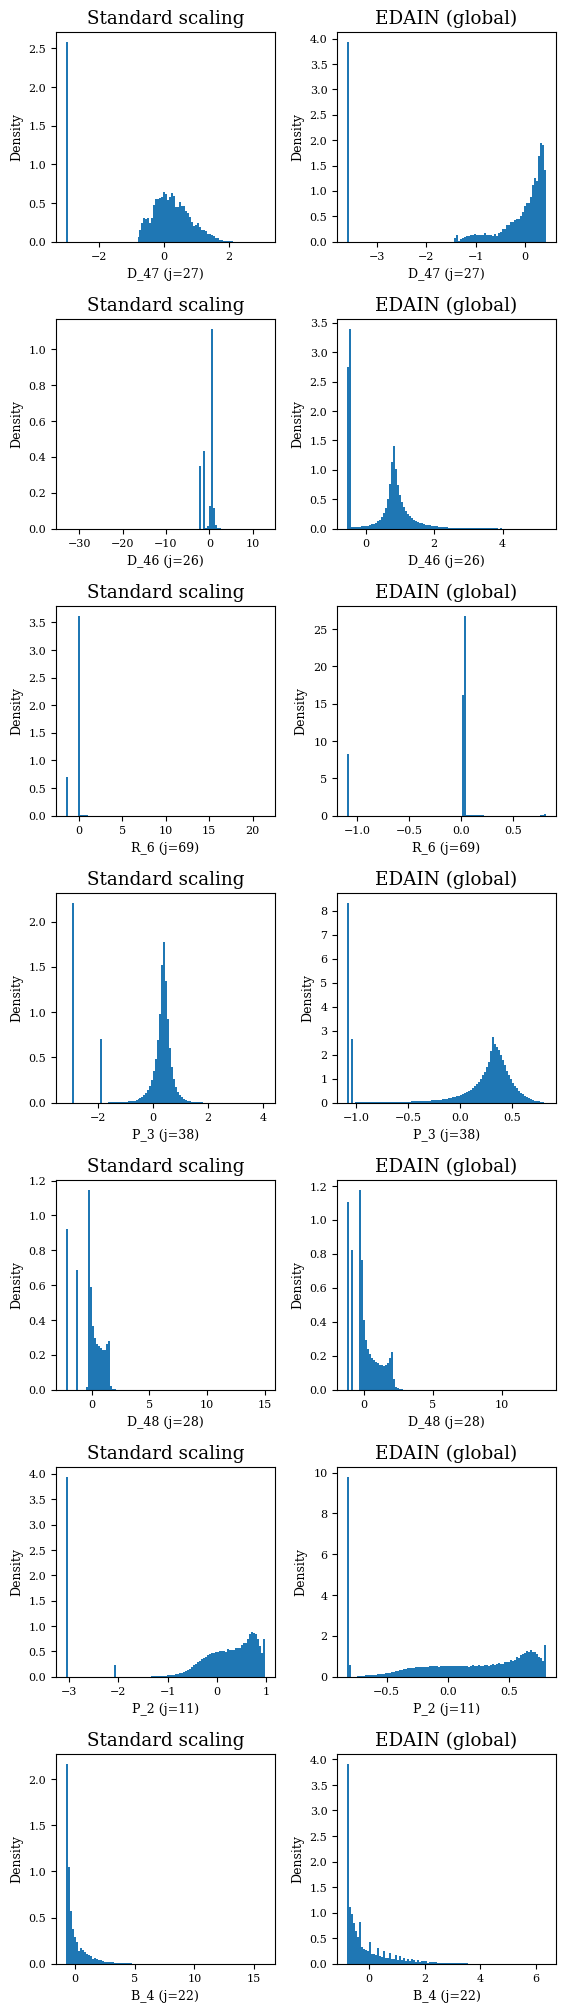

In [60]:
update_plot_params(**{"text.usetex":False})

fig, axs = plt.subplots(ncols=2, nrows=7, figsize=get_figsize(fraction=1, height_width_ratio=4*7/8))
ks = [16+11, 15+11, 58+11, 27+11, 28, 11, 22]
for i, k in enumerate(ks):
    axs[i, 0].hist(X_train[:, 0, k], density=True, bins=100)
    axs[i, 0].set_ylabel("Density")
    axs[i, 0].set_xlabel(f"{COLS[k]} (j={k})")
    axs[i, 0].set_title("Standard scaling")
    axs[i, 1].hist(X_transformed[:, 0, k], density=True, bins=100)
    axs[i, 1].set_ylabel("Density")
    axs[i, 1].set_title("EDAIN (global)")
    axs[i, 1].set_xlabel(f"{COLS[k]} (j={k})")
fig.tight_layout()
save_plot(fig, "amex_edain_example_transformations")
plt.show()

In [56]:
get_figsize

<function src.lib.plotting.get_figsize(width=418.25555, fraction=1.0, height_width_ratio=0.6180339887498949)>

In [40]:
torch.argmax(edain_model.preprocess.power_transform.lambd)

tensor(15)

In [42]:
torch.argmin(edain_model.preprocess.outlier_removal.alpha), torch.argmin(edain_model.preprocess.outlier_removal.log_cutoff)

(tensor(152), tensor(27))